## Importing necessary packages and loading dataset

In [61]:
import numpy as np

import pandas as pd

import statsmodels.api as sm

import seaborn as sns

import matplotlib.pyplot as plt

In [62]:
# Loading the hedge fund series
hedge_fund_series = pd.read_excel('../proshares_analysis_data.xlsx', sheet_name=1)

merrill_factors = pd.read_excel('../proshares_analysis_data.xlsx', sheet_name=2)

# Rename the unnamed column to 'Date'
hedge_fund_series.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Convert the 'Date' column to datetime
hedge_fund_series['date'] = pd.to_datetime(hedge_fund_series['date'])

In [65]:
annual_mean = hedge_fund_series.select_dtypes(include=[np.number]).mean() *12
annual_vol = hedge_fund_series.select_dtypes(include=[np.number]).std() * np.sqrt(12)

annualized_sharpe_ratio = annual_mean / annual_vol

pd.DataFrame({
    'Annual Mean': annual_mean,
    'Annual Volatility': annual_vol,
    'Sharpe Ratio': annualized_sharpe_ratio
})

,Annual Mean,Annual Volatility,Sharpe Ratio
HFRIFWI Index,0.051279,0.058796,0.872151
MLEIFCTR Index,0.038535,0.055240,0.697589
MLEIFCTX Index,0.036526,0.055102,0.662880
HDG US Equity,0.026880,0.057388,0.468396
QAI US Equity,0.028811,0.049823,0.578275


In [66]:
skewness = hedge_fund_series.select_dtypes(include=[np.number]).skew()
excess_kurtosis = hedge_fund_series.select_dtypes(include=[np.number]).kurtosis()
alpha = 0.05
VaR_05 = hedge_fund_series.quantile(alpha)
CVaR_05 = hedge_fund_series[hedge_fund_series <= VaR_05].mean()


In [67]:
# Prepare the data by sorting and setting 'date' as the index
df = hedge_fund_series.copy().sort_values('date')
df.set_index('date', inplace=True)

mdd_results = []

for column in df.columns:
    returns = df[column].dropna()
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = cumulative / running_max - 1

    # Index (date) where drawdown hits its minimum (trough)
    trough_date = drawdown.idxmin()
    max_drawdown = drawdown.loc[trough_date]

    # Peak date before trough
    peak_date = cumulative.loc[:trough_date].idxmax()

    # Find first date after trough where recovery to previous peak occurs
    recovery_date = None
    recovered = cumulative.loc[trough_date:][cumulative.loc[trough_date:] >= cumulative.loc[peak_date]]
    if not recovered.empty:
        recovery_date = recovered.index[0]

    mdd_results.append({
        'Fund': column,
        'Max_Drawdown': max_drawdown,
        'Peak_Date': peak_date,
        'Trough_Date': trough_date,
        'Recovery_Date': recovery_date
    })

mdd_table = pd.DataFrame(mdd_results)
mdd_table['Max_Drawdown'] = (mdd_table['Max_Drawdown'] * 100).round(2).astype(str) + '%'

print(mdd_table)

             Fund Max_Drawdown  Peak_Date Trough_Date Recovery_Date
0   HFRIFWI Index      -11.55% 2019-12-31  2020-03-31    2020-08-31
1  MLEIFCTR Index      -12.43% 2021-06-30  2022-09-30    2024-02-29
2  MLEIFCTX Index      -12.44% 2021-06-30  2022-09-30    2024-02-29
3   HDG US Equity      -14.07% 2021-06-30  2022-09-30    2024-07-31
4   QAI US Equity      -13.77% 2021-06-30  2022-09-30    2024-02-29


In [68]:
# Summarize the results

summary_df = pd.concat(
    [skewness, excess_kurtosis, VaR_05, CVaR_05],
    axis=1,
    keys=['skewness', 'excess_kurtosis', 'VaR_05', 'CVaR_05']
)

# Remove 'date' row if it exists
summary_df = summary_df.drop('date', errors='ignore')

mdd_table_for_concat = mdd_table.copy()
mdd_table_for_concat.set_index('Fund', inplace=True)

# Join Max_Drawdown and date columns to the summary
summary_combined = summary_df.join(mdd_table_for_concat[['Max_Drawdown', 'Peak_Date', 'Trough_Date', 'Recovery_Date']])

summary_combined


,skewness,excess_kurtosis,VaR_05,CVaR_05,Max_Drawdown,Peak_Date,Trough_Date,Recovery_Date
HFRIFWI Index,-0.948272,5.657351,-0.024008,-0.035992,-11.55%,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,-0.289982,1.630917,-0.027002,-0.034993,-12.43%,2021-06-30,2022-09-30,2024-02-29
MLEIFCTX Index,-0.273477,1.589790,-0.02697,-0.034937,-12.44%,2021-06-30,2022-09-30,2024-02-29
HDG US Equity,-0.274904,1.776481,-0.029919,-0.036831,-14.07%,2021-06-30,2022-09-30,2024-07-31
QAI US Equity,-0.433508,1.449184,-0.017171,-0.030995,-13.77%,2021-06-30,2022-09-30,2024-02-29


## Beta, IR, Alpha, Residual Vol and Treynor Ratio of the funds

In [8]:
results = []
for fund in hedge_fund_series.columns.drop('date'):
    df = pd.concat([hedge_fund_series[fund], merrill_factors['SPY US Equity']], axis=1).dropna()
    df.columns = ['fund', 'SPY US Equity']
    X = sm.add_constant(df['SPY US Equity'])
    y = df['fund']
    model = sm.OLS(y, X).fit()
    alpha_hat = model.params['const']
    beta_hat = model.params['SPY US Equity']
    resid = model.resid
    mean_fund = y.mean()
    sigma_e = resid.std()
    treynor = (12 * mean_fund) / beta_hat
    info_ratio = np.sqrt(12) * (alpha_hat / sigma_e)
    results.append({
        'Fund': fund,
        'Beta': beta_hat,
        'Treynor Ratio (annual)': treynor,
        'Information Ratio (annual)': info_ratio,
        'Alpha (monthly)': alpha_hat,
        'Residual Std (monthly)': sigma_e
    })
reg_summary = pd.DataFrame(results)
reg_summary

,Fund,Beta,Treynor Ratio (annual),Information Ratio (annual),Alpha (monthly),Residual Std (monthly)
0,HFRIFWI Index,0.346312,0.148072,0.055336,0.000144,0.009042
1,MLEIFCTR Index,0.342487,0.112514,-0.436440,-0.000920,0.007300
2,MLEIFCTX Index,0.341483,0.106963,-0.510548,-0.001075,0.007294
3,HDG US Equity,0.350602,0.076669,-0.862386,-0.001989,0.007989
4,QAI US Equity,0.301413,0.095587,-0.597796,-0.001235,0.007154


#### Hedge funds take roughly one-third of the market’s directional risk. They are partly market-neutral, so that explains that their returns depend less on broad equity movements. Finally, their alphas are small to slightly negative, suggesting that after adjusting for market exposure they have not outperformed SPY materially on a risk-adjusted basis during the sample.

#### QAI outperforms HDG on almost every way. It has a higher Treynor and (less negative) Information Ratios, smaller residual risk, and less negative alpha. HDG delivered weaker active management relative to SPY.

#### ML series, although similar in β, exhibit worse alpha and information ratios, implying they did not replicate HFRI’s positive value-added component. HDG and QAI capture the broad risk characteristics, while HFRI remains superior in overall performance.

## Correlation Matrix of the Funds and SPY

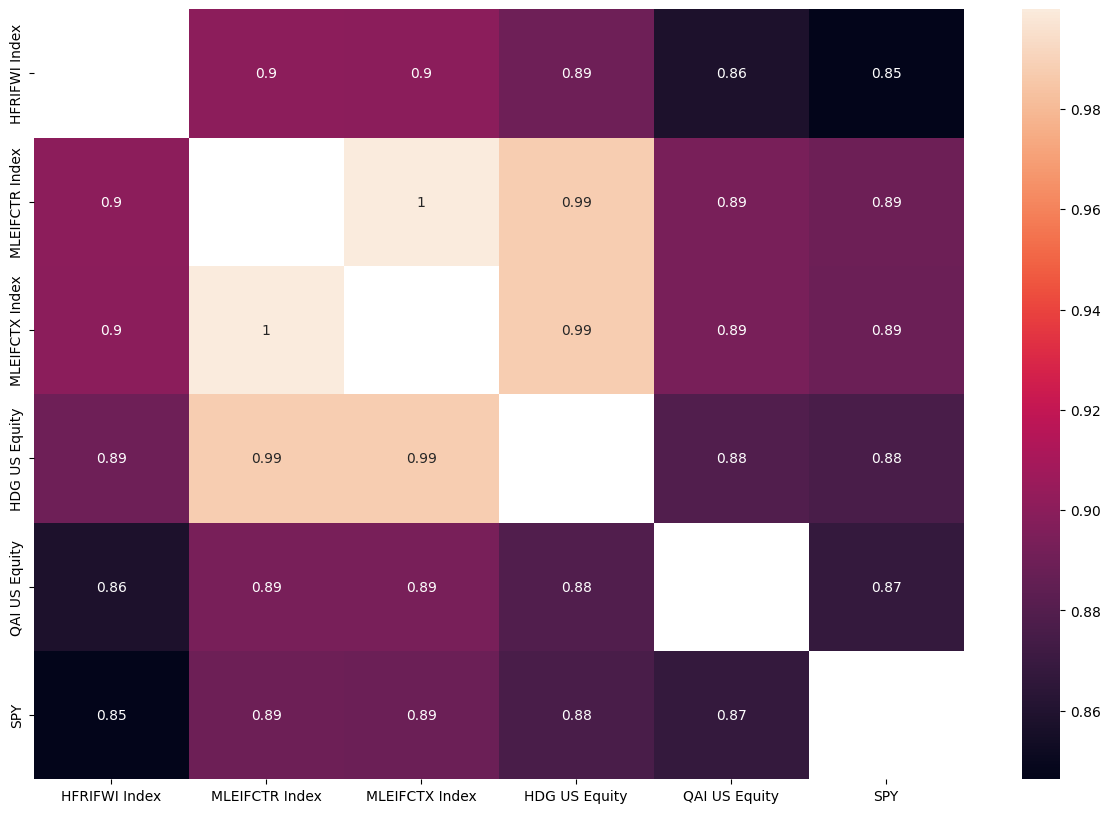

In [69]:
corr = hedge_fund_series.drop(columns=['date']).assign(SPY = merrill_factors['SPY US Equity']).corr()
np.fill_diagonal(corr.values,np.nan)
plt.figure(figsize=(15, 10)); sns.heatmap(corr, annot=True); plt.show()

#### QAI exhibits the lowest correlations with the other funds. In contrast, the ML series are highly correlated with each other, reflecting they may be similar strategies. Notably, HDG closely tracks both MLEIFCTR and MLEIFCTX, showing alignment in their return structure.

## Regression of HFRI to Merrill Factors

In [70]:
df = pd.concat([hedge_fund_series['HFRIFWI Index'], merrill_factors], axis=1).dropna()
X = sm.add_constant(df[merrill_factors.columns]).drop(columns=['Unnamed: 0']) # Adds a col of 1s to include an intercept in the model, i.e. alpha
y = df['HFRIFWI Index']
model = sm.OLS(y, X).fit()
tracking_error = model.resid.std()
r_square = model.rsquared
model.params

const            0.001149
SPY US Equity    0.043503
USGG3M Index     0.324931
EEM US Equity    0.085564
EFA US Equity    0.073994
EUO US Equity    0.029614
IWM US Equity    0.145824
dtype: float64

In [71]:
pd.DataFrame(
    {
        'Tracking Error': [tracking_error],
        'R-Squared': [r_square],
        'Intercept': [model.params["const"]],
        'Beta to SPY': [model.params["SPY US Equity"]],
        'Beta to USGG3M': [model.params["USGG3M Index"]],
        'Beta to EEM US': [model.params["EEM US Equity"]],
        'Beta to EFA US': [model.params["EFA US Equity"]],
        'Beta to EUO US': [model.params["EUO US Equity"]],
        'Beta to IWM US': [model.params["IWM US Equity"]],
        'Residual Vol': [model.resid.std()*np.sqrt(12)]
    }
)

,Tracking Error,R-Squared,Intercept,Beta to SPY,Beta to USGG3M,Beta to EEM US,Beta to EFA US,Beta to EUO US,Beta to IWM US,Residual Vol
0,0.006732,0.842694,0.001149,0.043503,0.324931,0.085564,0.073994,0.029614,0.145824,0.02332


#### All the betas are positive, which means that we do not require any short positions. The betas range from approximately 0.04 to 0.32, indicating that we do not need large positions to replicate the HFRI Index.

## Rolling Regression and OOS Performance

In [72]:
df = pd.concat([hedge_fund_series['HFRIFWI Index'], merrill_factors], axis=1).dropna()
X = sm.add_constant(df[merrill_factors.columns]).drop(columns=['Unnamed: 0']) # Adds a col of 1s to include an intercept in the model, i.e. alpha
y = df['HFRIFWI Index']

In [73]:
preds = []  # store OOS predictions
dates = []  # store prediction dates

for i in range(len(df) - 60):
    df_train = X.iloc[i:i+60].astype(float)
    df_test = X.iloc[i+60].astype(float)
    yy = y.iloc[i:i+60].astype(float)
    # Fit on TRAIN, then predict on the immediate next period
    model = sm.OLS(yy, df_train).fit()
    # Dot product for scalar: np.dot of DataFrame row (Series) and params
    y_hat = float(np.dot(df_test.values, model.params.values))
    preds.append(y_hat)
    dates.append(X.index[i+60])

In [74]:
# Build OOS replication series
replication = pd.Series(preds, index=dates, name='HFRI_OOS_Replication')

# Combine with actual returns for comparison
oos_df = pd.concat([y, replication], axis=1).dropna()
oos_df.columns = ['HFRI_Actual', 'HFRI_Replication']

# Evaluate replication performance
r2_oos = oos_df.corr().iloc[0, 1] ** 2
te = np.std(oos_df['HFRI_Actual'] - oos_df['HFRI_Replication'])

print(f"Out-of-sample R²: {r2_oos:.3f}")
print(f"Tracking Error (monthly): {te:.4f}")

Out-of-sample R²: 0.812
Tracking Error (monthly): 0.0079


In [75]:
oos_df.corr()

,HFRI_Actual,HFRI_Replication
HFRI_Actual,1.000000,0.901319
HFRI_Replication,0.901319,1.000000
